In [92]:
## --------------------------------------------------
# DEMO: Data exploration on counties database
## --------------------------------------------------

import numpy as np # import numpy matrix for calculus with matrices
import sys
sys.path.append('../../src/GLFMpython/')
import GLFM        # import General Latent Feature Model Library
import matplotlib.pyplot as plt # import plotting library
import time        # import time to be able to measure iteration speed

# import libraries for I/O of data
import cPickle

import pdb



In [93]:
# ---------------------------------------------
# 1. LOAD DATA TO BE EXPLORED
# ---------------------------------------------
print '\n 1. LOAD DATABASE TO EXPLORE\n'

with open('../../datasets/counties.pk','rb') as f:
    data = cPickle.load(f)





 1. LOAD DATABASE TO EXPLORE



In [94]:
# ---------------------------------------------
# 2. INITIALIZATION FOR GLFM ALGORITHM
# ---------------------------------------------
print '\n 2. INITIALIZATION\n'

print '\tSetting optional parameters for the GLFM model...'

params = dict()
params['Niter'] = 100  # number of algorithm iterations (for Gibbs sampler)
params['s2B'] = 1      # noise variance for feature values
params['s2u'] = 0.005  # auxiliary noise
params['alpha'] = 1    # mass parameter for the Indian Buffet Process

[N, D] = data['X'].shape


 2. INITIALIZATION

	Setting optional parameters for the GLFM model...


In [95]:
data['X'][0]

array([2.00000000e+00, 6.10000000e+01, 9.79999971e+00, 1.45000000e+01,
       3.22400000e+04, 1.79999995e+00, 3.08999996e+01, 5.59000015e+01,
       1.23000002e+01, 7.93173981e+01, 2.00017529e+01])

In [96]:
N

3141

In [97]:
D

11

In [98]:
data['C']

'cnppnpppppp'

Continuous variables:

Real-valued (encoded as 'g'): the attribute takes values in the real line.

Positive real-valued ('p'): the attribute takes values in the real line.


Discrete variables:

Categorical data ('c'): the attribute takes a value in a finite unordered set, e.g., {‘blue’,‘red’, ‘black’}.

Ordinal data ('o'): the attribute takes values in a finite ordered set, e.g., {‘never’, ‘often’, ‘always’}.

Count data ('n'): the attribute takes values in the set {0,...,∞}.

In [99]:
# pre-transform a subset of variables
idx_transform = [ 1, 4, 5, 10] # dimensions to be transformed
params['t'] = [None] * D
params['t_1'] = [None] * D
params['dt_1'] = [None] * D
params['ext_dataType'] = [None] * D
for rr in xrange(len(idx_transform)):
    r = idx_transform[rr]
    params['t_1'][r] = lambda x: np.log(x + 1) # transformation to apply to raw data
    params['t'][r] = lambda y: np.exp(y) - 1   # inverse transform to recover raw data
    params['dt_1'][r] = lambda x: 1/(x+1)      # derivative of inverse transform
    params['ext_dataType'][r] = 'p'    # change type of data due to transformation
# dimension 'White' need an inversion too
r = 9
params['t_1'][r] = lambda x: np.log((100-x)+1)  # transformation to apply to raw data
params['t'][r] = lambda y: - np.exp(y) + 101    # inverse transform to recover raw data
params['dt_1'][r] = lambda x: -1/(101 - x)      # derivative of inverse transform
params['ext_dataType'][r] = 'p'                 # change type of data due to transformation

params['maxK'] = 10     # maximum number of latent features for memory allocation
params['bias'] = 1      # 1 = fix first feature to be active for all patients 

print '\tInitializing Z...'

	Initializing Z...


In [100]:
Kinit = 2   # initial number of latent features
prob = 0.2  # probability of feature activation in matrix Z
hidden = dict()
if params['bias']:
    Zini = np.concatenate((np.ones((N,1)),(np.random.rand(N,Kinit-1) < 0.2)*1.0),axis=1)
    #Zini = [ones(N,1), double(rand(N,1)>0.8)]
else:
    #Zini = double(rand(N,1)>0.8)
    hidden['Z'] = (np.random.rand(N,Kinit) < prob) * 1.0
hidden['Z'] = Zini # N*K matrix of feature assignments

#hidden['Z'] = np.ascontiguousarray( ((np.random.rand(N,Kinit) < prob) * 1.0).astype('float64') )

In [103]:
# ---------------------------------------------
# 3. RUN INFERENCE FOR GLFM ALGORITHM
# ---------------------------------------------
print '\n 3. INFERENCE\n'

print '\tInfering latent features...'
tic = time.time()
hidden = GLFM.infer(data,hidden,params)
toc = time.time()
time = tic - toc
print '\tElapsed: #.2f seconds.' # (toc-tic)



 3. INFERENCE

	Infering latent features...
N=3141, D=11, K=2

[[2.00000000e+00 2.00000000e+00 2.00000000e+00 ... 5.10000000e+01
  5.10000000e+01 5.10000000e+01]
 [4.12713439e+00 4.21950771e+00 3.40119738e+00 ... 2.30258509e+00
  1.60943791e+00 1.38629436e+00]
 [9.79999971e+00 1.51999998e+01 1.45999999e+01 ... 5.29999995e+00
  1.38000002e+01 1.27000003e+01]
 ...
 [1.23000002e+01 1.65000000e+01 9.80000019e+00 ... 2.96000004e+01
  2.72000008e+01 2.73999996e+01]
 [3.07651018e+00 2.70504734e+00 3.81671179e+00 ... 1.18870099e+00
  1.98058992e+00 1.08646916e+00]
 [3.04460590e+00 2.62909449e+00 3.80758183e+00 ... 1.25446135e-01
  1.54355035e-01 4.49985948e-02]]
[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
In C++: transforming input data...
done

maxR = 51

Entering C++: Running Inference Routine...


Back to Python: OK

Kest=8, N=3141

Z_out loaded
B_out[D,Kest,maxR] where D=11, Kest=8, maxR=51
B_out loaded
theta_out loaded

	Elapsed time: 50.57 seconds.

	Elapsed: #.2f seconds.


In [105]:
hidden['Z'].shape[0]

3141

In [106]:
hidden['Z'].shape[1]

8

In [107]:
# ---------------------------------------------
# 4. PROCESS RESULTS
# ---------------------------------------------
print '\n 4. PROCESSING RESULTS\n'

Kest = hidden['B'].shape[1] # number of inferred latent features
D = hidden['B'].shape[0]    # number of dimensions



 4. PROCESSING RESULTS



In [108]:
Kest

8

In [109]:
D

11

In [111]:
## Predict MAP estimate for the whole matrix X
patterns = hidden['Z']
X_map = GLFM.computeMAP(data['C'], patterns, hidden, params)

In [86]:
patterns.shape[0]

3141

In [113]:
X_map

array([[11.        , 59.33676977, 13.67728361, ..., 11.05117303,
        76.20226494, 18.56292571],
       [44.        , 84.87242298, 13.07351459, ..., 20.1306758 ,
        91.14779893,  3.79766447],
       [11.        , 59.33676977, 13.67728361, ..., 11.05117303,
        76.20226494, 18.56292571],
       ...,
       [24.        , 15.8593887 , 16.29344848, ..., 24.56035228,
        98.49832917,  0.14073696],
       [24.        , 15.8593887 , 16.29344848, ..., 24.56035228,
        98.49832917,  0.14073696],
       [24.        , 15.8593887 , 16.29344848, ..., 24.56035228,
        98.49832917,  0.14073696]])

In [84]:
X_map.shape[0]

3141

In [114]:
## Plot Dimensions
sum(hidden['Z'])
th = 0.03 # threshold to filter out latent features that are not significant
feat_select = np.nonzero(sum(hidden['Z']) >= N*th)[0] # filter features with insufficient number of obs. assigned
hidden['Z']= hidden['Z'][:,feat_select]
hidden['B']= hidden['B'][:,feat_select,:]
sum(hidden['Z'])

array([3141., 1377.,  917.,  129.,  117.])

In [115]:
hidden['Z'][0]

array([1., 0., 1., 0., 0.])

In [116]:
[patterns, C, L] = GLFM.get_feature_patterns_sorted(hidden['Z']) # returns sorted patterns



0. [1. 0. 0. 0. 0.]: 1026
1. [1. 1. 0. 0. 0.]: 1006
2. [1. 0. 1. 0. 0.]: 533
3. [1. 1. 1. 0. 0.]: 334
4. [1. 0. 0. 0. 1.]: 92
5. [1. 0. 0. 1. 0.]: 72
6. [1. 0. 1. 1. 0.]: 28
7. [1. 1. 0. 1. 0.]: 17
8. [1. 0. 1. 0. 1.]: 12
9. [1. 1. 0. 0. 1.]: 9
10. [1. 1. 1. 1. 0.]: 8
11. [1. 1. 0. 1. 1.]: 2
12. [1. 1. 1. 1. 1.]: 1
13. [1. 0. 1. 1. 1.]: 1


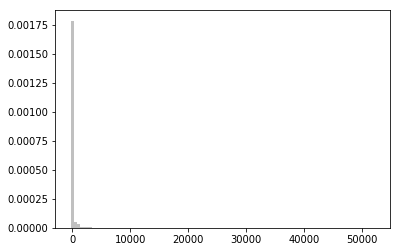

dim=1



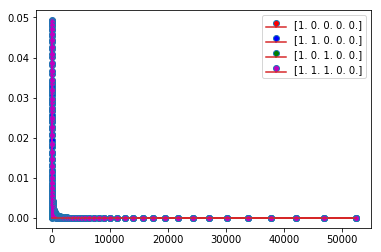

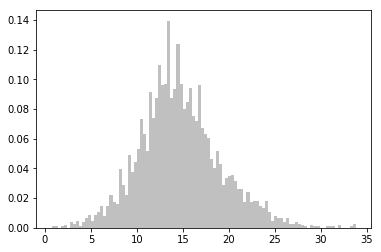

dim=2



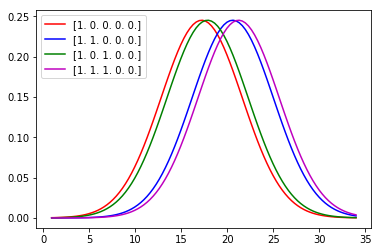

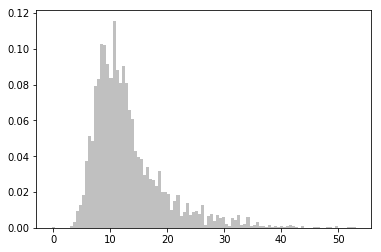

dim=3



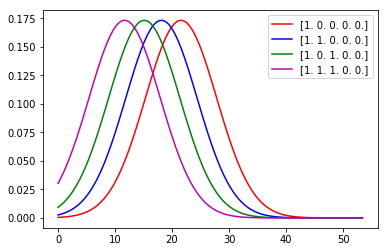

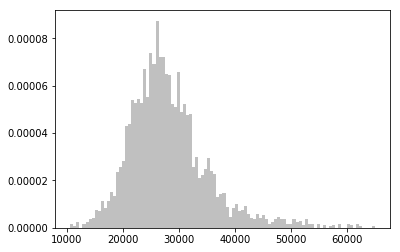

dim=4



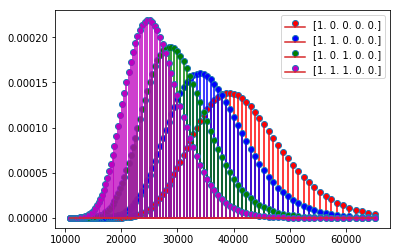

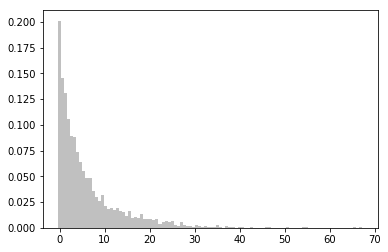

dim=5



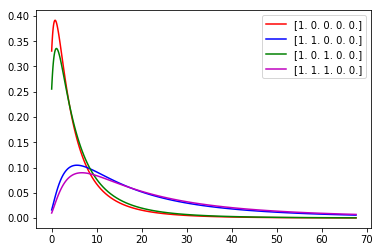

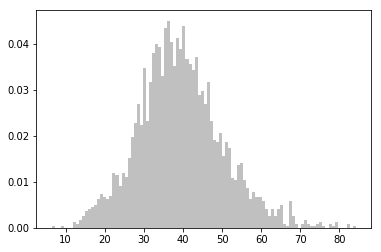

dim=6



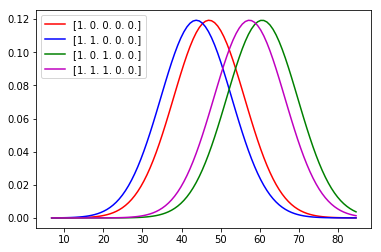

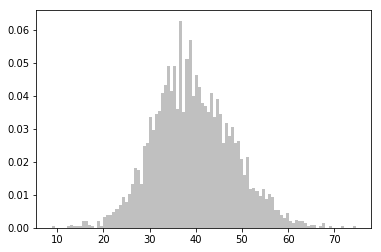

dim=7



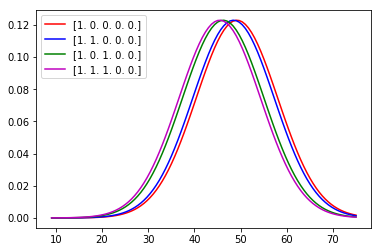

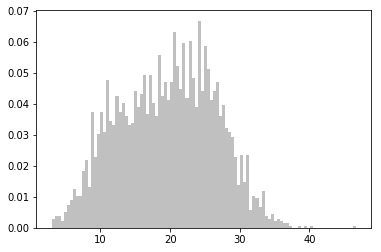

dim=8



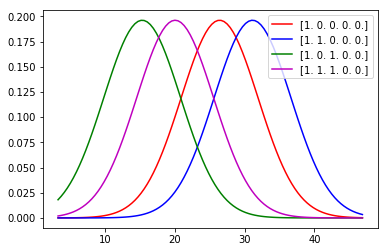

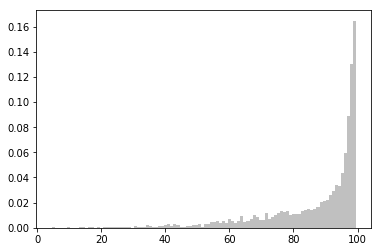

dim=9



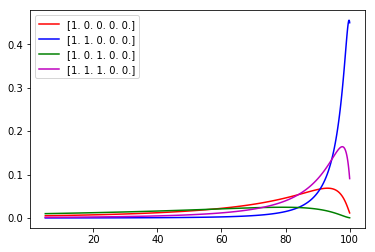

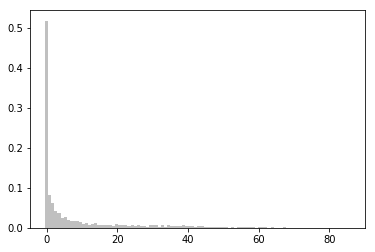

dim=10



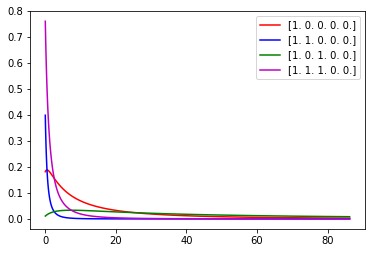

SUCCESSFUL


In [117]:

# choose patterns corresponding to activation of each feature
Zp = np.eye(Kest)
Zp[:,1] = 1 # bias active

Zp = patterns[L > 240,:]

colors = np.array([[ 0, 102, 255], [153, 51, 255], \
    [204, 204, 0], [255, 102, 102], \
    [0, 204, 102], [255, 51, 255]])
colors = colors / 255.0
colors[3,:] = [0.9290, 0.6940, 0.1250]
colors[5,:] = [0.4660, 0.6740, 0.1880]




# # change order of colors
# colors = colors([3 5 4 2 1],:)
# colors(4,:) = [0 255 255] ./255

idxD = range(1,D) # idxD = 2:size(data.X,2)
styles = None
#GLFM.plotPatterns(data, hidden, params, Zp)
GLFM.plotPatterns(data, hidden, params, Zp, colors=colors[:Zp.shape[0],:],idxD=idxD)
# plot_all_dimensions(data, hidden, params, Zp, leg, colors, styles)

print "SUCCESSFUL"

In [57]:
hidden['B'][0]

array([[-1.08284831e+00, -3.58797171e-01, -8.63334279e-01,
        -4.61040839e-01,  1.82009975e-01, -2.41022483e-01,
        -4.55131002e-01, -1.35677217e+00, -1.06914747e+00,
         1.32977122e-01,  4.53005822e-01, -7.81616155e-01,
        -6.45395699e-01, -8.24458773e-01,  5.69223197e-02,
        -7.05503456e-02, -8.85997259e-02, -2.97731110e-01,
        -4.50435903e-01, -4.90304394e-01, -2.44507130e-01,
        -6.39131441e-01, -8.54445540e-02, -6.11071635e-01,
        -1.24667545e-01, -6.14454487e-01, -1.09851595e+00,
         2.42968942e-01, -9.49325280e-01, -8.16152784e-01,
        -6.98021935e-01, -3.27390711e-01, -4.94766105e-01,
        -1.06878500e+00,  1.65483656e-03,  2.46668488e-01,
         1.09451387e-01, -4.89584549e-01,  1.14029444e-02,
        -1.08947894e+00, -2.28159385e-01, -7.45788536e-01,
        -1.88595515e-01,  7.15378243e-01, -6.49399952e-01,
         3.52269328e-01, -9.95045744e-01, -2.83750482e-01,
        -5.14193365e-01, -9.55062734e-01,  0.00000000e+0